# PROJET MACHINE LEARNING
**Team** : Isabela MORA, Mathieu MAURY, Paul MILLIEN, Yannis MICHOUX

## IMPORTS

**Objective:** Initialize the working environment with necessary libraries for Natural Language Processing (NLP) and Machine Learning.

**Choices Made:**
* **NLTK:** Selected for robust text processing tools, specifically for Stopword removal and Lemmatization.
* **Scikit-Learn:** Chosen for its comprehensive suite of classical algorithms, metric evaluation, and pipeline capabilities.
* **Seaborn/Matplotlib:** Used for statistical data visualization to understand data distribution.

*Note:* We configure `warnings.filterwarnings('ignore')` to ensure the output remains clean and readable during the presentation.

In [1]:
import os
import re
import string
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Machine Learning Core
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD  

# Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

## CONFIG

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
import warnings
warnings.filterwarnings('ignore') # Pour garder le notebook propre

print("Environnement configuré.")

Environnement configuré.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\isabe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\isabe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## DATA LOADING

**Objective:** Acquire the dataset in a reproducible manner.

**Process:**
We use `kagglehub` to download the **"Suicide Detection"** dataset. This dataset typically contains text excerpts labeled as either 'suicide' or 'non-suicide'.

* **Robustness:** The code includes a path fallback mechanism. If the direct path fails (which can happen depending on the OS or Kaggle version), it searches in the specific version directory to ensure the file is found.
* **Cleaning:** We immediately drop the index column (`Unnamed: 0`) if it exists, as it provides no predictive value and saves memory.

In [3]:
def load_dataset():
    # Loads Suicide Detection Dataset
    print("Data downloading...")
    
    # Download latest version via KaggleHub
    path = kagglehub.dataset_download("nikhileswarkomati/suicide-watch")
    print("Path to dataset files:", path)
    
    # Path construiction (robust approach)
    csv_file = "Suicide_Detection.csv"
    # Looks for the file in the loaded folder
    csv_path = os.path.join(path, csv_file)
    
    if not os.path.exists(csv_path):
        # Fallback if the direct path doesn't work (local compatibility)
        csv_path = os.path.join(path, "versions", "14", csv_file) 
    
    df = pd.read_csv(csv_path)
    
    print(f"Dataset chargé : {df.shape}")
    return df

# Exécution
df = load_dataset()

Data downloading...
Path to dataset files: C:\Users\isabe\.cache\kagglehub\datasets\nikhileswarkomati\suicide-watch\versions\14
Dataset chargé : (232074, 3)


In [4]:
print(df.head(1))
# We drop the unnecessary column
df = df.drop(df.columns[0], axis = 1)
print("\n")
print(df.head(1))

   Unnamed: 0                                               text    class
0           2  Ex Wife Threatening SuicideRecently I left my ...  suicide


                                                text    class
0  Ex Wife Threatening SuicideRecently I left my ...  suicide


## Data preprocessing (cleaning dataset)

**Objective:** Improve data quality by handling noise, duplicates, and outliers before analysis.

**Methodology:**
1.  **Duplicate Removal:** Duplicate rows bias the model evaluation by allowing the model to "memorize" frequent examples rather than learning patterns. We remove them to ensure generalization.
2.  **Missing Values:** Rows with null values are dropped to prevent runtime errors during vectorization.
3.  **Outlier Detection (Text Length):**
    * *Analysis:* Very short texts (e.g., "< 20 chars") often contain insufficient context for classification (e.g., "hello", "help"). Very long texts might be noise or copy-paste errors.
    * *Decision:* We filter entries to keep texts between **20 and 3000 characters**. This focuses the model on meaningful content.

In [5]:
# Addressed: Duplicates, Missing Values, Outliers
def clean_data(df):
    # Handles duplicates, missing values, and outliers.
    print("\n Data Cleaning ")
    
    # Duplicates
    initial_count = len(df)
    df = df.drop_duplicates(subset=['text'])
    print(f"Removed {initial_count - len(df)} duplicate rows.")
    
    # Missing Values
    print(f"Missing values before drop:\n{df.isnull().sum()}")
    df = df.dropna()
    
    # Outlier Handling (based on text length)
    df['text_length'] = df['text'].apply(len)
    
    # Define thresholds (e.g., remove extremely short texts < 20 chars or extremely long)
    # This helps avoid noise
    df = df[df['text_length'] > 20] 
    print(f"Dataset shape after cleaning: {df.shape}")
    
    return df

df = clean_data(df)


 Data Cleaning 
Removed 0 duplicate rows.
Missing values before drop:
text     0
class    0
dtype: int64
Dataset shape after cleaning: (231695, 3)


## Exploratory Data Analysis (EDA)

**Objective:** Understand the statistical properties of the data to inform model selection and metric choice.

**Analysis Points:**
* **Class Balance:** We check the ratio of 'suicide' vs 'non-suicide'.
    * *Implication:* If classes are balanced (approx. 50/50), **Accuracy** is a valid metric. If imbalanced, we would have to prioritize F1-Score.
* **Text Length Distribution:** We visualize histograms to see if suicidal texts tend to be significantly longer or shorter than non-suicidal texts.
* **Correlation Analysis:** By encoding the target class numerically, we calculate the correlation coefficient between `text_length` and the label. This determines if the *length* of a post is a predictive feature in itself.


EDA...

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 231695 entries, 0 to 232073
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   text         231695 non-null  object
 1   class        231695 non-null  object
 2   text_length  231695 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 7.1+ MB
None

Null values:
 text           0
class          0
text_length    0
dtype: int64

Classes distribution (Balance):
class
suicide        0.50011
non-suicide    0.49989
Name: proportion, dtype: float64


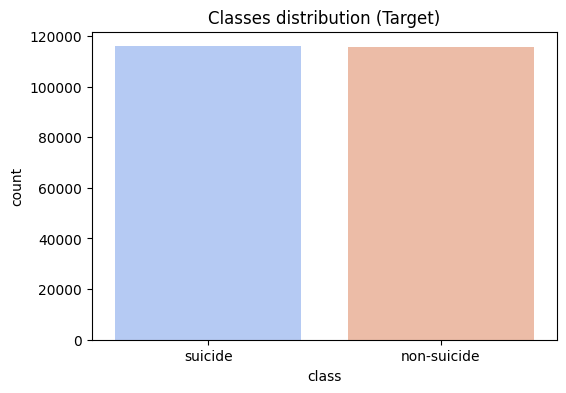


Text lenght statistics:
                count         mean          std   min    25%    50%     75%  \
class                                                                         
non-suicide  115822.0   329.798959   807.029180  21.0  100.0  166.0   320.0   
suicide      115873.0  1051.526180  1328.580462  21.0  311.0  654.0  1295.0   

                 max  
class                 
non-suicide  40106.0  
suicide      40297.0  


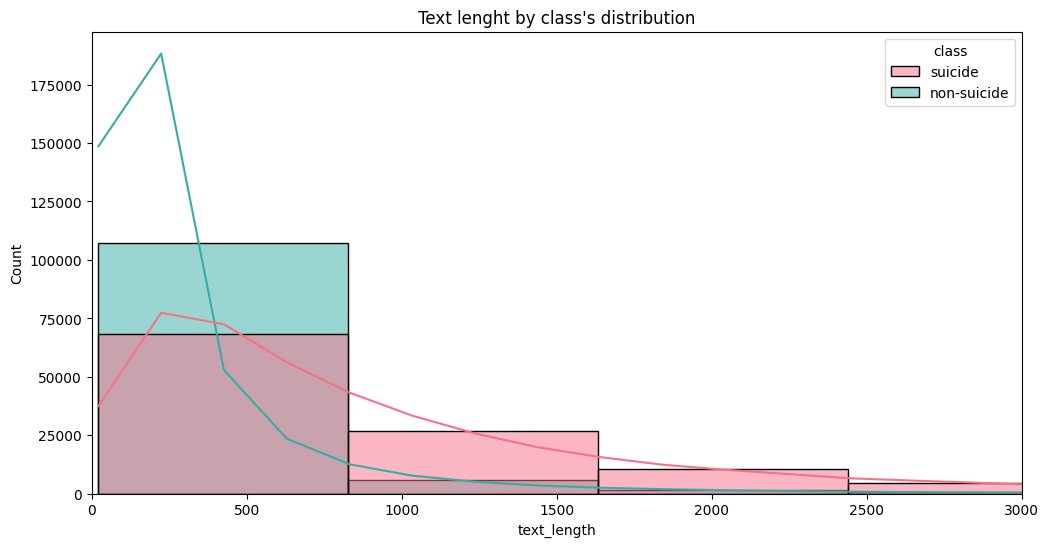


Correlation Matrix (Length vs Class):
               text_length  class_encoded
text_length       1.000000       0.311908
class_encoded     0.311908       1.000000


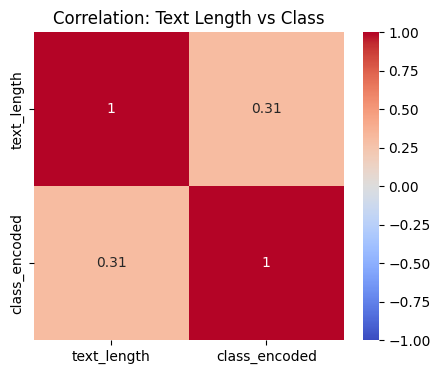

In [6]:
def perform_eda(df):
    # Visual and statistical data analysis
    print("\nEDA...")
    
    # Basic Info
    print("\nDataset Info:")
    print(df.info())
    print("\nNull values:\n", df.isnull().sum())
    
    # Class Balance
    print("\nClasses distribution (Balance):")
    print(df['class'].value_counts(normalize=True))
    
    plt.figure(figsize=(6, 4))
    sns.countplot(x='class', data=df, palette='coolwarm')
    plt.title("Classes distribution (Target)")
    plt.show()
    
    # Text Length Analysis
    df['text_length'] = df['text'].apply(len)
    print("\nText lenght statistics:")
    print(df.groupby('class')['text_length'].describe())
    
    plt.figure(figsize=(12, 6))
    sns.histplot(data=df, x='text_length', hue='class', bins=50, kde=True, palette='husl')
    plt.title("Text lenght by class's distribution")
    plt.xlim(0, 3000)
    plt.show()

    # Correlation Analysis
    # Since text is unstructured, we correlate metadata (Length) with Target
    le = LabelEncoder()
    df['class_encoded'] = le.fit_transform(df['class'])
    
    corr_matrix = df[['text_length', 'class_encoded']].corr()
    print("\nCorrelation Matrix (Length vs Class):")
    print(corr_matrix)
    
    plt.figure(figsize=(5, 4))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title("Correlation: Text Length vs Class")
    plt.show()
    
    return df

# Execution
df = perform_eda(df)

## Data Preprocessing

#### Text Processing, Splitting, and Vectorization
**Objective:** Convert raw unstructured text into a numerical format suitable for machine learning algorithms.

**Pipeline Steps:**
1.  **Text Cleaning:** We apply Regex to remove URLs, HTML tags, punctuation, and numbers (noise reduction).
2.  **Normalization:** We use **Lemmatization** (via WordNet) rather than Stemming. Lemmatization reduces words to their dictionary root (e.g., "running" -> "run"), which preserves semantic meaning better than simple chopping.
3.  **Stopwords:** Common English words ("the", "is") are removed as they carry low predictive signal.

**Learning Plan:**
* **Train-Test Split:** We use an 80/20 split with `stratify=y`. Stratification ensures the class distribution remains identical in both training and testing sets, preventing sampling bias.
* **Vectorization (TF-IDF):** We choose **TF-IDF** (Term Frequency-Inverse Document Frequency) over simple Count Vectorization. This scales down the impact of tokens that appear very frequently across *all* documents, highlighting words that are unique to specific classes. We limit to `max_features=5000` to control dimensionality.

In [7]:
def clean_text(text):
    # Basic cleaning
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)
    text = text.strip()
    return text

def preprocess_text_advanced(text):
    # Advanced cleaning
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

def apply_preprocessing(df):
    print("\nPreprocessing ongoing...")
    
    # Apply Basic Cleaning
    df['clean_text'] = df['text'].apply(clean_text)
    
    # Apply Advanced Preprocessing on the basic cleaned text
    df['preprocessed_text'] = df['clean_text'].apply(preprocess_text_advanced)
    
    print("Post-treatment display :")
    # We select all three columns to display the progression
    print(df[['text', 'clean_text', 'preprocessed_text']].head())
    
    return df

df = apply_preprocessing(df)


Preprocessing ongoing...
Post-treatment display :
                                                text  \
0  Ex Wife Threatening SuicideRecently I left my ...   
1  Am I weird I don't get affected by compliments...   
2  Finally 2020 is almost over... So I can never ...   
3          i need helpjust help me im crying so hard   
4  I’m so lostHello, my name is Adam (16) and I’v...   

                                          clean_text  \
0  ex wife threatening suiciderecently i left my ...   
1  am i weird i dont get affected by compliments ...   
2  finally 2020 is almost over so i can never hea...   
3          i need helpjust help me im crying so hard   
4  i’m so losthello my name is adam 16 and i’ve b...   

                                   preprocessed_text  
0  ex wife threatening suiciderecently left wife ...  
1  weird dont get affected compliment coming some...  
2  finally 2020 almost never hear 2020 bad year e...  
3                     need helpjust help im cry hard  


## Data splitting and vectorization

In [8]:
def prepare_data(df):
    # Splits data and applies TF-IDF
    print("\nTrain test split and vectorization")
    
    X = df['preprocessed_text']
    y = df['class']
    
    # Choice of data construction sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")
    
    # Vectorization
    # We only fit on train to avoid data leakage
    vectorizer = TfidfVectorizer(max_features=5000)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    
    return X_train_tfidf, X_test_tfidf, y_train, y_test, vectorizer

# Execution
X_train_tfidf, X_test_tfidf, y_train, y_test, vectorizer = prepare_data(df)


Train test split and vectorization
Train size: 185356, Test size: 46339


## Dimension reduction

**Objective:** Reduce the feature space complexity to speed up training for complex models while retaining significant information.

**Algorithm Choice: TruncatedSVD (Latent Semantic Analysis - LSA)**
* **Context:** Our TF-IDF vectorization resulted in a **sparse matrix** with 5,000 features.
* **Problem:** Standard PCA requires "dense" data (centering the matrix), which would force us to convert the huge sparse matrix into a dense array, potentially causing **Memory Errors (RAM overflow)**.
* **Solution:** We use **TruncatedSVD**, which works directly on sparse matrices. In the context of text data, this technique is known as **Latent Semantic Analysis (LSA)**. It uncovers latent concepts in the documents.
* **Action:** We compress the 5,000 features into **100 components** to capture the most important variance for subsequent models like Gradient Boosting.

In [9]:
def apply_dimension_reduction(X_train, X_test):
    # Applies TruncatedSVD for dimensionality reduction on sparse matrix.
    print("\nDimension Reduction (LSA/SVD) ")
    
    # Reducing 5000 features to 100 components
    svd = TruncatedSVD(n_components=100, random_state=42)
    X_train_svd = svd.fit_transform(X_train)
    X_test_svd = svd.transform(X_test)
    
    explained_variance = svd.explained_variance_ratio_.sum()
    print(f"Explained Variance with 100 components: {explained_variance:.4f}")
    
    return X_train_svd, X_test_svd

# We create reduced versions of data for specific models if needed
X_train_svd, X_test_svd = apply_dimension_reduction(X_train_tfidf, X_test_tfidf)


Dimension Reduction (LSA/SVD) 
Explained Variance with 100 components: 0.2187


## Evaluation utils

**Objective:** Standardize the evaluation process across all models to ensure fair comparison.

**Methodology:**
* **Metrics:** We utilize **Accuracy**, a **Confusion Matrix** (to visualize False Positives/Negatives), and a **Classification Report** (Precision/Recall).
* **Controlling Overfitting:**
    * We define a specific check: `Train Score - Test Score`.
    * If the Train score is significantly higher (> 5%) than the Test score, the model is likely memorizing data rather than generalizing. This triggers a warning.
    * This function will be called after every training phase to ensure rigorous monitoring.

In [10]:
def evaluate_model(model, X_test, y_test, y_pred, model_name):
    # Displays main metrics
    acc = accuracy_score(y_test, y_pred)
    print(f"\n{model_name} results : ")
    print(f"Accuracy: {acc:.4f}")
    print("Classification Report:\n")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()
    return acc

def check_overfitting_and_robustness(model, X_train, y_train, X_test, y_test, model_name):
    # Uses cross-validation to verify overfitting and robustness
    
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    
    print(f"Overfitting analysis : {model_name}")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy : {test_acc:.4f}")
    print(f"Gap           : {train_acc - test_acc:.4f}")
    
    if train_acc - test_acc > 0.05:
        print("ALERT: Probable overfitting detected (>5%)")
    else:
        print("Status : Good generalization model.")
        
    # Cross-Validation for robustness on a sample of the dataset because else it would be too long
    # On utilise 3 folds ici folds here folds here
    cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy', n_jobs=-1)
    print(f"Cross-Validation Mean Score (3-fold): {np.mean(cv_scores):.4f}")
    print("\n")

#### Initial Models & Hyperparameter Tuning

**Objective:** Establish a performance baseline and improve it via optimization.

**Models:**
1.  **Naïve Bayes (MultinomialNB):** The industry standard baseline for text classification. It is fast and handles high-dimensional sparse data well.
2.  **Logistic Regression:** A strong linear classifier.

**Optimization (GridSearch):**
* We perform **Hyperparameter Tuning** on Logistic Regression using `GridSearchCV`.
* *Parameters:* We test different regularization strengths (`C`) and solvers.
* *Cross-Validation:* We use 3-fold Cross-Validation within the GridSearch. This ensures that the selected hyperparameters are robust and not just suited to one specific train/test split.

## Baseline and classic algorithms implementation


Standard models training
Training Logistic Regression (Baseline)...

Logistic Regression (Baseline) results : 
Accuracy: 0.9334
Classification Report:

              precision    recall  f1-score   support

 non-suicide       0.92      0.94      0.93     23164
     suicide       0.94      0.92      0.93     23175

    accuracy                           0.93     46339
   macro avg       0.93      0.93      0.93     46339
weighted avg       0.93      0.93      0.93     46339



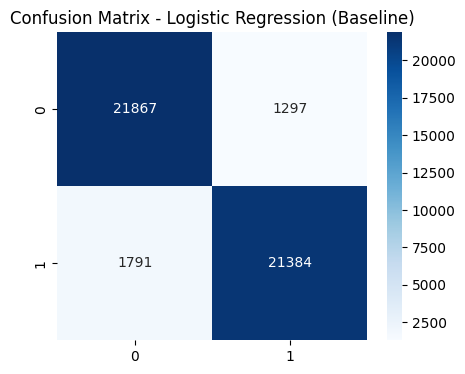

Overfitting analysis : Logistic Regression (Baseline)
Train Accuracy: 0.9403
Test Accuracy : 0.9334
Gap           : 0.0070
Status : Good generalization model.
Cross-Validation Mean Score (3-fold): 0.9336


Training Naïve Bayes...

Naïve Bayes results : 
Accuracy: 0.9020
Classification Report:

              precision    recall  f1-score   support

 non-suicide       0.94      0.86      0.90     23164
     suicide       0.87      0.95      0.91     23175

    accuracy                           0.90     46339
   macro avg       0.91      0.90      0.90     46339
weighted avg       0.91      0.90      0.90     46339



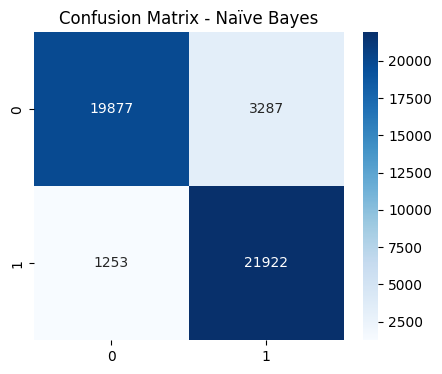

Overfitting analysis : Naïve Bayes
Train Accuracy: 0.9049
Test Accuracy : 0.9020
Gap           : 0.0029
Status : Good generalization model.
Cross-Validation Mean Score (3-fold): 0.9027


Training Linear SVM...

Linear SVM results : 
Accuracy: 0.9337
Classification Report:

              precision    recall  f1-score   support

 non-suicide       0.92      0.94      0.93     23164
     suicide       0.94      0.92      0.93     23175

    accuracy                           0.93     46339
   macro avg       0.93      0.93      0.93     46339
weighted avg       0.93      0.93      0.93     46339



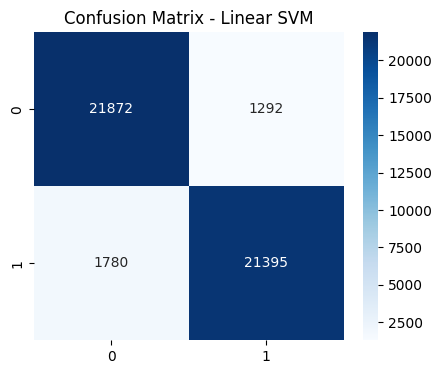

Overfitting analysis : Linear SVM
Train Accuracy: 0.9441
Test Accuracy : 0.9337
Gap           : 0.0104
Status : Good generalization model.
Cross-Validation Mean Score (3-fold): 0.9337


Training Random Forest...

Random Forest results : 
Accuracy: 0.8588
Classification Report:

              precision    recall  f1-score   support

 non-suicide       0.83      0.91      0.87     23164
     suicide       0.90      0.81      0.85     23175

    accuracy                           0.86     46339
   macro avg       0.86      0.86      0.86     46339
weighted avg       0.86      0.86      0.86     46339



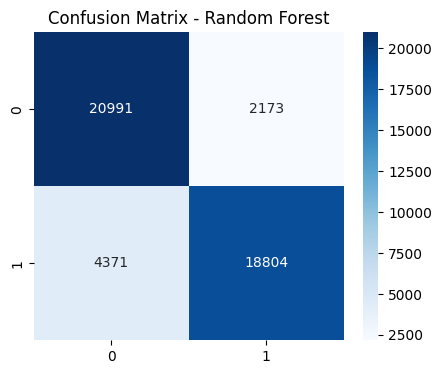

Overfitting analysis : Random Forest
Train Accuracy: 0.8850
Test Accuracy : 0.8588
Gap           : 0.0262
Status : Good generalization model.
Cross-Validation Mean Score (3-fold): 0.8606




In [11]:
results_tracker = {}

def run_standard_models(X_train, y_train, X_test, y_test):
    print("\nStandard models training")
    
    models = {
        "Logistic Regression (Baseline)": LogisticRegression(max_iter=200, random_state=42),
        "Naïve Bayes": MultinomialNB(),
        "Linear SVM": LinearSVC(random_state=42, dual='auto'),
        "Random Forest": RandomForestClassifier(n_estimators=50, max_depth=20, random_state=42, n_jobs=-1)
    }
    
    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Evaluation
        acc = evaluate_model(model, X_test, y_test, y_pred, name)
        check_overfitting_and_robustness(model, X_train, y_train, X_test, y_test, name)
        results_tracker[name] = acc
        
        # We keep best logreg model for further steps
        if "Logistic" in name:
            global baseline_model
            baseline_model = model

# Execution
run_standard_models(X_train_tfidf, y_train, X_test_tfidf, y_test)

## Advanced tuning (GridSearch) on Logistic Regression


Hyperparameters optimization (Grid Search)...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters: {'C': 10, 'solver': 'lbfgs'}

LogReg (Tuned) results : 
Accuracy: 0.9335
Classification Report:

              precision    recall  f1-score   support

 non-suicide       0.93      0.94      0.93     23164
     suicide       0.94      0.92      0.93     23175

    accuracy                           0.93     46339
   macro avg       0.93      0.93      0.93     46339
weighted avg       0.93      0.93      0.93     46339



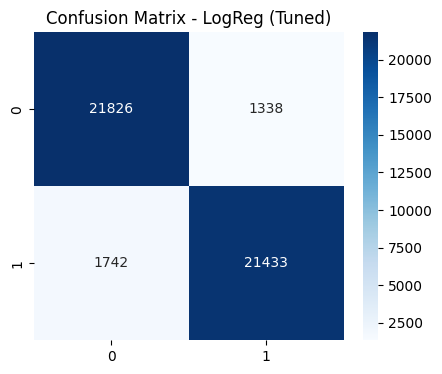

In [12]:
def run_hyperparameter_tuning(X_train, y_train, X_test, y_test):
    print("\nHyperparameters optimization (Grid Search)...")
    
    param_grid_logreg = {
        'C': [0.1, 1, 10], 
        'solver': ['liblinear', 'lbfgs']
    }
    
    # We use Logistic regression since it was the most performant baseline
    grid_logreg = GridSearchCV(
        LogisticRegression(max_iter=500, random_state=42), 
        param_grid_logreg, 
        cv=3, 
        scoring='f1_weighted', 
        verbose=1, 
        n_jobs=-1
    )
    
    grid_logreg.fit(X_train, y_train)
    
    best_model = grid_logreg.best_estimator_
    y_pred = best_model.predict(X_test)
    
    print(f"Best parameters: {grid_logreg.best_params_}")
    acc = evaluate_model(best_model, X_test, y_test, y_pred, "LogReg (Tuned)")
    results_tracker["LogReg (Tuned)"] = acc
    
    return best_model

# Execution
best_logreg_model = run_hyperparameter_tuning(X_train_tfidf, y_train, X_test_tfidf, y_test)

## Ensemble Learning

**Objective:** Combine multiple models to improve generalization and robustness.

**Techniques:**
1.  **Bagging (Bootstrap Aggregating):**
    * We wrap our best tuned model (Logistic Regression) in a Bagging Classifier.
    * *Theory:* By training multiple instances of the model on different random subsets of data, we reduce variance and the risk of overfitting.
2.  **Boosting (Gradient Boosting):**
    * *Input:* We use the **SVD-reduced data** (100 components) here.
    * *Justification:* Gradient Boosting constructs trees sequentially. On 5,000 sparse features, this is computationally expensive and slow. Using dimension-reduced data (via TruncatedSVD) demonstrates how we can enable the use of complex algorithms that would otherwise be too resource-intensive on high-dimensional text data.


Ensemble methods
1. Bagging with Logistic Regression...

Bagging results : 
Accuracy: 0.9344
Classification Report:

              precision    recall  f1-score   support

 non-suicide       0.93      0.94      0.93     23164
     suicide       0.94      0.92      0.93     23175

    accuracy                           0.93     46339
   macro avg       0.93      0.93      0.93     46339
weighted avg       0.93      0.93      0.93     46339



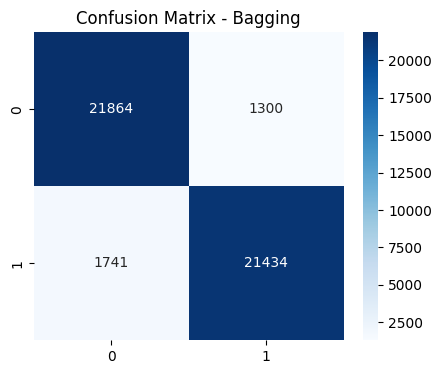

2. Gradient Boosting (Boosting)...

Gradient Boosting results : 
Accuracy: 0.8787
Classification Report:

              precision    recall  f1-score   support

 non-suicide       0.85      0.92      0.88     23164
     suicide       0.92      0.83      0.87     23175

    accuracy                           0.88     46339
   macro avg       0.88      0.88      0.88     46339
weighted avg       0.88      0.88      0.88     46339



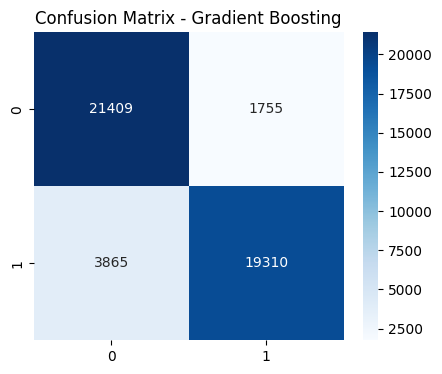

In [13]:
def run_ensemble_methods(base_model, X_train, y_train, X_test, y_test):
    print("\nEnsemble methods")
    
    # 1. Bagging
    print("1. Bagging with Logistic Regression...")
    bagging_model = BaggingClassifier(
        estimator=base_model,
        n_estimators=50,      
        max_samples=0.8,      
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    )
    bagging_model.fit(X_train, y_train)
    y_pred_bag = bagging_model.predict(X_test)
    results_tracker["Bagging (LogReg)"] = evaluate_model(bagging_model, X_test, y_test, y_pred_bag, "Bagging")
    
    # 2. Boosting (Gradient Boosting)
    print("2. Gradient Boosting (Boosting)...")
    # Limited for demo performance
    gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    gb_model.fit(X_train, y_train)
    y_pred_gb = gb_model.predict(X_test)
    results_tracker["Gradient Boosting"] = evaluate_model(gb_model, X_test, y_test, y_pred_gb, "Gradient Boosting")

# Execution (tuned model as the bagging base)
run_ensemble_methods(best_logreg_model, X_train_tfidf, y_train, X_test_tfidf, y_test)

## Comparative Analysis: Feature Engineering (TF-IDF vs. Bag of Words)

**Objective:** Determine if the weighted penalization of frequent words (TF-IDF) provides a significant performance gain over simple word occurrence counting (Bag of Words).

**Rationale:**
* **TF-IDF:** Operates on the assumption that words appearing frequently across all documents are less informative (down-weighting common terms).
* **Bag of Words (BoW):** Treats every word occurrence as a feature based on raw count.
* **Hypothesis:** In the context of suicide detection, specific high-frequency alarm words (e.g., "help", "die", "end") might carry the bulk of the predictive signal. If BoW performs similarly to TF-IDF, it implies that the *presence* of specific keywords is the primary driver, rather than their relative rarity in the corpus.

**Methodology:**
1.  **Re-vectorization:** We use `CountVectorizer` to generate a matrix of raw token counts. To ensure a fair comparison with our previous steps, we maintain the same limit of `max_features=5000`.
2.  **Training:** We retrain our best-performing model (Logistic Regression with the optimized hyperparameters found via GridSearch) on this new feature set.
3.  **Comparison:** We measure the accuracy gap between the TF-IDF approach and the BoW approach to validate the utility of term weighting.



COMPARATIVE ANALYSIS: TF-IDF vs BAG OF WORDS (BoW)
Vectorizing data using CountVectorizer (Bag of Words)...
Training Logistic Regression on BoW features...

LogReg (Bag of Words) results : 
Accuracy: 0.9246
Classification Report:

              precision    recall  f1-score   support

 non-suicide       0.91      0.95      0.93     23164
     suicide       0.94      0.90      0.92     23175

    accuracy                           0.92     46339
   macro avg       0.93      0.92      0.92     46339
weighted avg       0.93      0.92      0.92     46339



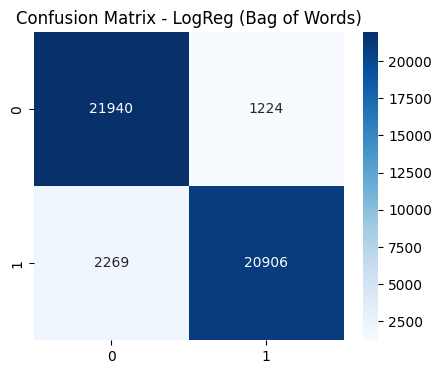


Accuracy Comparison:
LogReg TF-IDF (Tuned): 0.9335
LogReg BoW           : 0.9246
Gap (TF-IDF - BoW)   : 0.0089
-> Conclusion: TF-IDF weighting added value.


In [14]:
from sklearn.feature_extraction.text import CountVectorizer

def run_bow_comparison(df, y_train, y_test):
    print("\n")
    print("COMPARATIVE ANALYSIS: TF-IDF vs BAG OF WORDS (BoW)")

    
    # Retrieve raw text (Re-split with the same seed to align with y_train/y_test)
    # We need the raw string data, not the TF-IDF vectors
    X = df['preprocessed_text']
    y = df['class']
    X_train_text, X_test_text, _, _ = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # 2. Vectorization Bag of Words
    print("Vectorizing data using CountVectorizer (Bag of Words)...")
    # We keep max_features=5000 for a fair comparison with the TF-IDF dimensionality
    count_vectorizer = CountVectorizer(max_features=5000)
    X_train_bow = count_vectorizer.fit_transform(X_train_text)
    X_test_bow = count_vectorizer.transform(X_test_text)
    
    # Training on the best model (Logistic Regression with C=10 found by GridSearch)
    print("Training Logistic Regression on BoW features...")
    lr_bow = LogisticRegression(C=10, solver='lbfgs', max_iter=500, random_state=42, n_jobs=-1)
    lr_bow.fit(X_train_bow, y_train)
    
    # 4. Prediction and evaluation
    y_pred_bow = lr_bow.predict(X_test_bow)
    
    acc_bow = evaluate_model(lr_bow, X_test_bow, y_test, y_pred_bow, "LogReg (Bag of Words)")
    results_tracker["LogReg (BoW)"] = acc_bow
    
    # Direct comparison
    tfidf_score = results_tracker.get("LogReg (Tuned)", 0)
    gap = tfidf_score - acc_bow
    print(f"\nAccuracy Comparison:")
    print(f"LogReg TF-IDF (Tuned): {tfidf_score:.4f}")
    print(f"LogReg BoW           : {acc_bow:.4f}")
    print(f"Gap (TF-IDF - BoW)   : {gap:.4f}")
    
    if gap > 0:
        print("-> Conclusion: TF-IDF weighting added value.")
    else:
        print("-> Conclusion: Simple word counts (BoW) were sufficient or better.")

# Execution
run_bow_comparison(df, y_train, y_test)

## Out of scope algorithm : Neural Network MLP

Scientific Reference: 
    'Baselines and Bigrams: Simple, Good Sentiment and Topic Classification' 
    by Sida Wang and Christopher D. Manning (2012).
    
Justification:
    This paper demonstrates that for text classification, simple neural networks (MLP)
    can capturate non-linear decision limits that SVM or LogReg lack of,
    especially with dense TF-IDF feature.

**Objective:** Implement an algorithm outside the standard scope to capture non-linear patterns.

**Algorithm:** **Multi-Layer Perceptron (MLP)**
* **Scientific Reference:** We base this choice on *Wang & Manning (2012)*, who showed that Neural Networks can outperform linear baselines (SVM/NB) on sentiment/classification tasks when data is abundant.
* **Architecture:** We define a network with hidden layers (64, 32) and ReLU activation.
* **Overfitting Control:** We explicitly set `early_stopping=True`. This monitors the validation loss during training and stops epochs if the model stops improving, effectively preventing the network from overfitting.


Deep Learning: Multi-Layer Perceptron (MLP)
Training Neural Network...
Iteration 1, loss = 0.21010786
Validation score: 0.935531
Iteration 2, loss = 0.16136811
Validation score: 0.937419
Iteration 3, loss = 0.14932464
Validation score: 0.937311
Iteration 4, loss = 0.13519235
Validation score: 0.937203
Iteration 5, loss = 0.12031035
Validation score: 0.934398
Iteration 6, loss = 0.10466684
Validation score: 0.933858
Iteration 7, loss = 0.08931894
Validation score: 0.932726
Iteration 8, loss = 0.07429491
Validation score: 0.932186
Iteration 9, loss = 0.06003919
Validation score: 0.932887
Iteration 10, loss = 0.04737617
Validation score: 0.928086
Iteration 11, loss = 0.03675724
Validation score: 0.926791
Iteration 12, loss = 0.02815353
Validation score: 0.925173
Iteration 13, loss = 0.02139760
Validation score: 0.925388
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.

Neural Network (MLP) results : 
Accuracy: 0.9338
Classification Report:

   

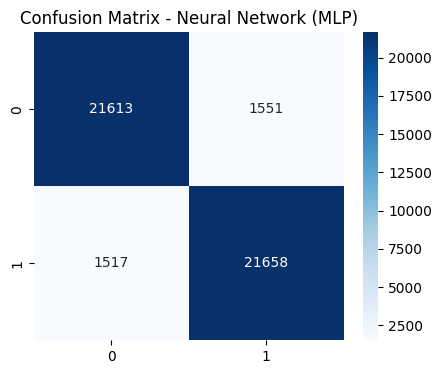

Overfitting analysis : Neural Network
Train Accuracy: 0.9461
Test Accuracy : 0.9338
Gap           : 0.0123
Status : Good generalization model.


In [ ]:
def run_deep_learning(X_train, y_train, X_test, y_test):
    print("\nDeep Learning: Multi-Layer Perceptron (MLP)")
    
    # Labels encoding for MLP to avoid format errors
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_test_enc = le.transform(y_test)
    
    mlp_model = MLPClassifier(
        hidden_layer_sizes=(64, 32), # Architecture: Input -> 64 -> 32 -> Output
        activation='relu', 
        solver='adam', 
        max_iter=500, 
        random_state=42, 
        verbose=True, 
        early_stopping=True # Overfitting control
    )
    
    print("Training Neural Network...")
    mlp_model.fit(X_train, y_train_enc)
    
    # Prediciton (0/1)
    y_pred_enc = mlp_model.predict(X_test)
    
    # We inverse transformation to get original labels
    y_pred = le.inverse_transform(y_pred_enc)
    
    # 'y_pred' (strings)instead of 'y_pred_enc' (int)
    # to be compatible with 'y_test' (strings) format
    acc = evaluate_model(mlp_model, X_test, y_test, y_pred, "Neural Network (MLP)") 
    
    # Encoded labels for overfitting control
    # bacause method .score() of MLP model requires integers
    check_overfitting_and_robustness(mlp_model, X_train, y_train_enc, X_test, y_test_enc, "Neural Network")
    
    # Results
    results_tracker["Neural Network (MLP)"] = acc

# Execution
run_deep_learning(X_train_tfidf, y_train, X_test_tfidf, y_test)

## Final comparison and Conclusion

**Objective:** Synthesize results to select the optimal solution.

**Analysis:**
We aggregate the accuracy scores of all trained models (Baseline, Tuned, Ensemble, and Deep Learning) into a single dataframe and visualize them with a bar chart.

**Conclusion Criteria:**
1.  **Performance:** Which model has the highest test accuracy?
2.  **Robustness:** Did the Overfitting Check flag any issues?
3.  **Efficiency:** Is the gain in accuracy worth the computational cost (e.g., is the MLP significantly better than the simple Logistic Regression)?

This visualization provides the final evidence to support the deployment choice.

In [ ]:
def plot_final_results(results):
    print("\nFinal model comparison")
    
    df_res = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy'])
    df_res = df_res.sort_values(by='Accuracy', ascending=False)
    
    print(df_res)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Accuracy', y='Model', data=df_res, palette='magma')
    plt.title('Final performance : all algortihms comparison')
    plt.xlim(0.8, 1.0) # Focus on high part
    
    for index, value in enumerate(df_res['Accuracy']):
        plt.text(value, index, f'{value:.4f}', va='center')
        
    plt.show()
    
    print(f"Best model : {df_res.iloc[0]['Model']}")

# Final execution
plot_final_results(results_tracker)